<!-- dom:TITLE: Primi esercizi di Machine Learning: Regressione Lineare e Validazione dei modelli -->
# Esercitazione 2: Metodi di allenamento e minimizzazione
<!-- dom:AUTHOR: Carlo Barbieri at Department of Physics, Università Statale di Milano -->
<!-- Author: -->  

C. Barbieri, $\qquad$ **Novembre 2022**.


In questa esercitazione mireremo a vedere alcuni esempi di implementazione degli algoritmi di minimizzazione e argomenti correlati.

Oltre a questo notebook la cartella contiene i seguenti due file:
+ **Esempi_Minimizzazione.ipynb** discute l'implementazione dei metodi delle *discesa del gradiente standard* e della *discesa del gradiente stocatoca*. Vi si possono trovare semplici implementazioni in python oltre ad alcune funzioni già esistenti della libreria *scikit-learn*. La seconda parte del Notebook compre metodi di controllo della velocita di apprendimento che verranno poi visti anche a lezione.
+ **Autograd_e_DifferenziazioneAutomatica.ipynb** non è necessario per svolgere l'esercizio qui sotto ma è inteso a dare una introduzione alle techniche di differenziazione automatica. Questo è un metodo computazionale molto potente per il calcolo delle derivate che facilità l'implementazione di reti neurali anche molto complesse. Qui si possono trovare alcuni esempi introduttivi in una libreria in particolare: **Autograd**.

L'esercitazione proposta qui sotto mira ad estendere le conoscenze acquisite dal primo file al caso di una funzione molto più complicata dei (faculi) esempi là trattati.  Si consiglia di leggere la prima parte di **Esempi_Minimizzazione.ipynb** prima di procedere con l'esercizio.


### Testi di riferimento

Il materiale discusso in queste lezioni è estratto da: [Aurelien Geron's chapter 4](https://gitlab.com/craolus/MachineLearning-con-applicazioni/-/blob/master/Documenti/Monografie/TensorflowML.pdf) e [Murphy sections 8.3 and 8.5](https://gitlab.com/craolus/MachineLearning-con-applicazioni/-/blob/master/Documenti/Monografie/MachineLearningMurphy.pdf) 



---

# Esercizio sulla discesa del gradiente stocastica

Gli esempi visti sopra danno una buona dimostrazione di come la discesa del gradiente e la sua versione stocastica possono essere usati per allenare un modello di regressione lineare. Gli esempi funzionano molto bene...  soprattutto perché la regressione lineare ha una funzone di costo convessa con un minimo globale, per la quale anche la normale discesa del gradiente è garantita di trovare il minimo.

In questo esercizio vi si chiede di applicare i metodi di minimizzazione visti sopra ad una funzione molto più complicata, con svariati minimi locali. La discesa del gradiente standard rimane quasi sempre intrappolata in un minimo locale. La domanda a cui rispondere è: quanto meglio si può fare con un approccio stocastico?

Consideriamo la seguante funzione di due variabili:

$$
 f(x,y) = a(x^2 + y^2) + \cos(x) \, \sin(y- \frac \pi 2)
$$

con $a=0.03$. Il primo termine ha un minimo globale a $x$=$y$=0  mentre il secondo produce oscillazioni periodiche lungo entrabi gli assi ma è traslato in modo che uno dei suoi minimi locali coincide col minimo del primo termine. Il risultato è una funzione con un _minimo globale_ circondato da una _griglia di minimi locali_ disposti a schacchiera.

Il codice seguente mostra il comportamento di $f(x,y)$.

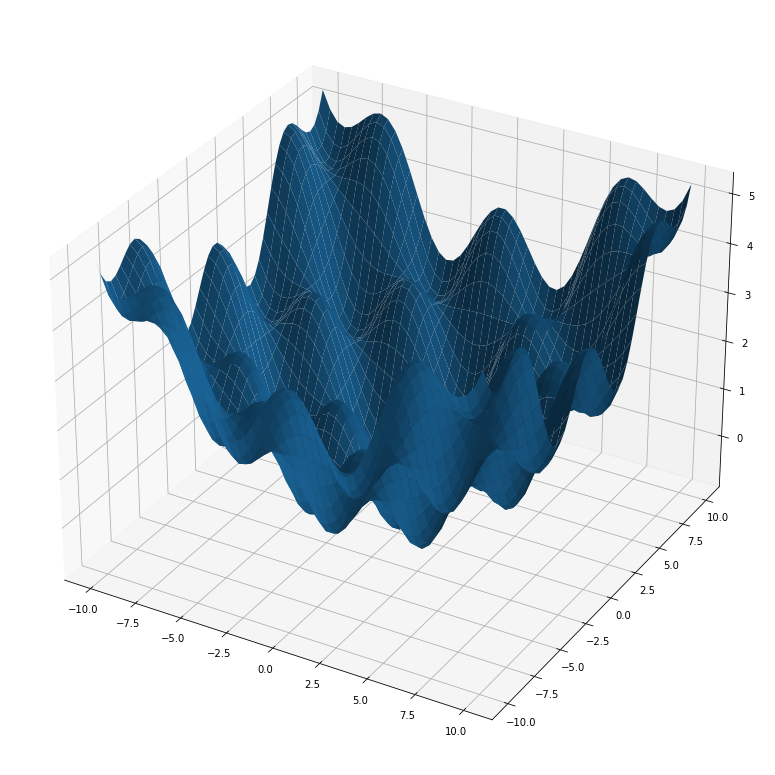

In [6]:
%matplotlib inline

import numpy as np
import numpy.linalg as la

import scipy.optimize as sopt

import matplotlib.pyplot as pt
from mpl_toolkits.mplot3d import axes3d

def f(x):
    #return np.cos(.4*x[0])*np.sin(.4*x[1]-3.14/2.) -np.sin(np.sqrt(x[0]**2 + x[1]**2))/((x[0]**2 + x[1]**2)**.5)
    #return .001*x[0]**2 -np.sin(np.sqrt(x[0]**2 + x[1]**2))/((x[0]**2 + x[1]**2)**.5)
    return np.cos(x[0])*np.sin(x[1]-3.14/2.) + 0.03*(x[0]**2 + x[1]**2)


fig = pt.figure(figsize=(16,14))
ax = pt.axes(projection="3d") 

xmesh, ymesh = np.mgrid[-10:10:50j,-10:10:50j]
fmesh = f(np.array([xmesh, ymesh]))
ax.plot_surface(xmesh, ymesh, fmesh)


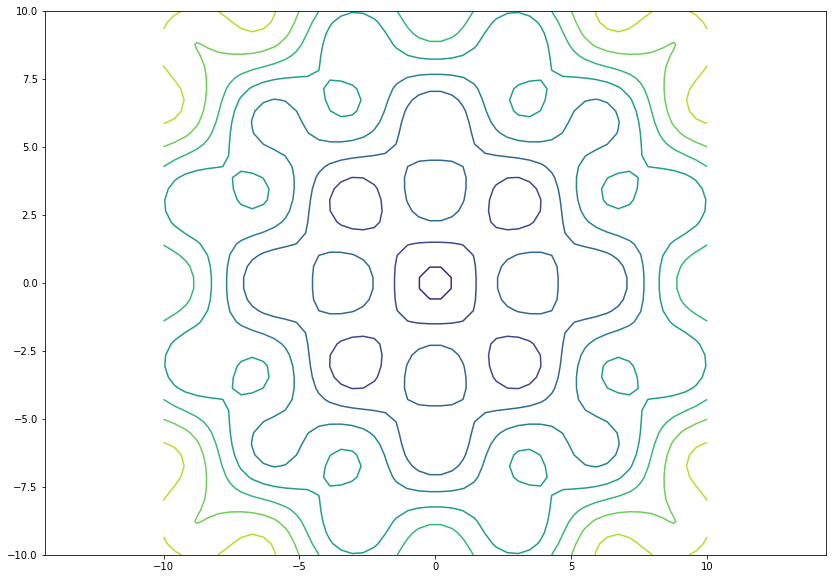

In [7]:
pt.figure(figsize=(14,10))
pt.axis("equal")
pt.contour(xmesh, ymesh, fmesh)

Il gradiente di $f(x,y)$ è dato da:

$$
 {\bf g}(x,y) = \nabla f(x,y) =  \begin{bmatrix}
   2ax - \sin(x) \, \sin(y- \frac \pi 2) \\
   2ay + \cos(x) \, \cos(y- \frac \pi 2)
   \end{bmatrix}
$$

In ML La discesa stocastica viene implementata calcolando di volta in volta un gradiente su un minibach di pochi dati (o addirittura, un solo dato) di campionamento. Come visto a lezione, essendo questo un campionamento parziale, equivale ad introdurre un errore stocastico sul gradiente. Nell'esercizio, simuleremo quesrta situazione aggiungendo un errore statistico tratto da una distribuzione normale (gaussiana) a media nulla:

$$
 {\bf g}_{SDG}(x,y) =  {\bf g}(x,y) + \cal {N}^2(0,\sigma)= \begin{bmatrix}
   2ax - \sin(x) \, \sin(y- \frac \pi 2) +  \cal {N}(0,\sigma)\\
   2ay + \cos(x) \, \cos(y- \frac \pi 2) +  \cal {N}(0,\sigma)
   \end{bmatrix}
$$

dove si può iniziare sceglendo una varianza unitaria, $\sigma^2=1$, perché viene riscalata dalla velocità di apprendimento. 

La velocità di apprendimento alla k-esima iterazione viene aggiornata come

$$\gamma_k = \frac{\gamma_0}{1+ c k} \, , $$

dove $\gamma_0$ e $c$ sono parametri da ottimizzare empiricamente.

**L'esercizio richiede di studiare i punti seguenti:**

+ Implementare un algoritmo di GD sia con passo fisso $\gamma_{GD}$ che con minimizzazione lineare. 
+ Generare un grafico della traiettoria di convergenza in alcuni casi. Si veda come varia rispetto alla velocita di apprendimento $\gamma_{GD}$.
+ Implementare l'algoritmo di SGD, usando una velocità di apprendimento via via più piccola come dall'equazione sopra.
+ Diseganre alcune traiettorie ed il valore della funzione in funzione delle iterazioni.
+ Per un punto di partenza fisso, qual'è la parcentuale ci successo per il SGD?



**Ulteriori esperimenti** si possono fare variando la funzione da minimizzare. Ecco alcune possibilità:

$$
  f(x,y) = \cos(b x) \, \sin( b y-\frac \pi 2) - \frac{\sin(\sqrt{x^2 + y^2})}{\sqrt{x^2 + y^2}} \, \quad \text{con}~~ b=0.4 \, ,
$$

oppure

$$
f(x,y) = \frac{x^2}{c} -\frac{\sin(\sqrt{x^2 + y^2})}{\sqrt{x^2 + y^2}} \, \quad \text{con}~~ c=1000 \,.
$$

---